# 5.5 Model Selection and Hyperparameter Tuning

This section will use the tools developed in the previous section to answer two important questions:

- Model Selection: How do we determine which model is best?
- Hyperparameter Tuning: How do we choose hyperparameters, such as $k$ in $k$-nearest neighbors?

In the previous section, we saw how to use training and validation sets to estimate how well the model will perform on future data. A natural way to decide between competing models (or hyperparameters) is to choose the one that minimizes the validation error.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

housing = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/AmesHousing.txt",
                      sep="\t")
housing

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
2929,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,188000


## $K$-Fold Cross Validation

Previously, we carried out cross validation by splitting the data into 2 halves, alternately using one half to train the model and the other to evaluate the model. In general, we can split the data into $k$ subsamples, alternately training the data on $k-1$ subsamples and evaluating the model on the $1$ remaining subsample, i.e., the validation set. This produces $k$ somewhat independent estimates of the test error. This procedure is known as **$k$-fold cross validation**. (Be careful not to confuse the $k$ in $k$-fold cross validation with the $k$ in $k$-nearest neighbors.) Therefore, the specific version of cross validation that we saw earlier is $2$-fold cross validation.

A schematic of $4$-fold cross validation is shown below.

![](k-folds.png)

Implementing $k$-fold cross validation from scratch for $k > 2$ is straightforward but messy, so we will usually let Scikit-Learn do it for us.

## Cross Validation in Scikit-Learn

Scikit-Learn provides a function, `cross_val_score`, that will carry out all aspects of $k$-fold cross validation: 

1. split the data into $k$ subsamples
2. combine the first $k-1$ subsamples into a training set and train the model
3. evaluate the model predictions on the last ($k$th) held-out subsample
4. repeat steps 2-3 $k$ times (i.e. $k$ "folds"), each time holding out a different one of the $k$ subsamples
4. calculate $k$ "scores", one from each validation set

There is one subtlety to keep in mind. Training a $k$-nearest neighbors model is not just about fitting the model; it also involves dummifying the categorical variables and scaling the variables. These preprocessing steps should be included in the cross-validation process. They cannot be done ahead of time.

For example, suppose we run $5$-fold cross validation. Then:

- When subsamples 1-4 are used for training and subsample 5 for validation, the observations have to be standardized with respect to the mean and SD of subsamples 1-4.
- When subsamples 2-5 are used for training and subsample 1 for validation, the observations have to be standardized with respect to the mean and SD of subsamples 2-5.
- And so on.

We cannot simply standardize all of the data once at the beginning and run cross validation on the standardized data. To do so would be allowing the model to peek at the validation set during training. That's because each training set would be standardized with respect to a mean and SD that is calculated from all data, including the validation set. To be completely above board, we should standardize each training set with respect to the mean and SD of just that training set.

Fortunately, Scikit-Learn provides a `Pipeline` object that allows us to chain these preprocessing steps together with the model we want to fit.

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

# get the features (in dict format) and the labels
# (do not split into training and validation sets)
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood"]
X_dict = housing[features].to_dict(orient="records")
y = housing["SalePrice"]

# specify the pipeline
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()
model = KNeighborsRegressor(n_neighbors=10)
pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])

This entire `Pipeline` can be passed to `cross_val_score`, along with the data, the number of folds $k$ (`cv`), and the type of score (`scoring`). So $5$-fold cross validation in Scikit-Learn would look as follows:

In [4]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X_dict, y, 
                         cv=5, scoring="neg_mean_squared_error")
scores

array([ -1.98025092e+09,  -1.47950953e+09,  -1.54632969e+09,
        -1.87662563e+09,  -1.42167566e+09])

Notice that we get five (negative) validation MSEs, one from each of the 5 folds. `cross_val_score` returns the _negative_ MSE, instead of the MSE, because by definition, a _higher_ score is better. (Since we want the MSE to be as _low_ as possible, we want the negative MSE to be as _high_ as possible.)

To come up with a single overall estimate of the test MSE, we flip the signs and average the MSEs:

In [5]:
np.mean(-scores)

1660878287.4356349

The RMSE is the square root of the MSE:

In [6]:
np.sqrt(np.mean(-scores))

40753.874508267734

## Hyperparameter Tuning

How do we choose $k$? We can simply try all values of $k$ and pick the one with the smallest (test) MSE.

4     1.390511e+09
3     1.405909e+09
          ...     
49    2.208727e+09
50    2.216495e+09
Length: 50, dtype: float64

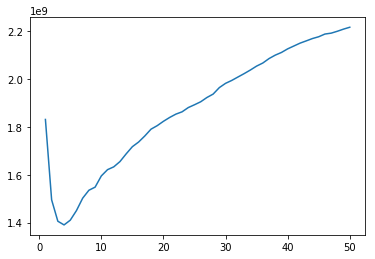

In [7]:
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()

# calculates estimate of test error based on 10-fold cross validation
def get_cv_error(k):
    model = KNeighborsRegressor(n_neighbors=k)
    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
    mse = np.mean(-cross_val_score(
        pipeline, X_dict, y, 
        cv=10, scoring="neg_mean_squared_error"
    ))
    return mse
    
ks = pd.Series(range(1, 51))
ks.index = range(1, 51)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line()
test_errs.sort_values()

The MSE is minimized near $k = 4$, which suggests that a $4$-nearest neighbors model is optimal for prediction.

## Model Selection

Suppose we are not sure whether `Yr Sold` should be included in the $4$-nearest neighbors model or not. To determine whether or not it should be included, we can fit a model with `Yr Sold` included and another model with it excluded, and see which model has the better (test) MSE.

In [ ]:
vec = DictVectorizer(sparse=False)
scaler = StandardScaler()
model = KNeighborsRegressor(n_neighbors=4)
pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])

In [ ]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood"]
X_dict = housing[features].to_dict(orient="records")
np.mean(
    -cross_val_score(pipeline, X_dict, y, cv=10, scoring="neg_mean_squared_error")
)

In [ ]:
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built",
            "Neighborhood"]
X_dict = housing[features].to_dict(orient="records")
-cross_val_score(pipeline, X_dict, y, cv=10, scoring="neg_mean_squared_error").mean()

The MSE actually goes down when we remove `Yr Sold`, so it seems that the model is better off without this variable.